<a href="https://colab.research.google.com/github/FrancLis/Multivariate-Time-Series-Forecasting/blob/main/Multivariate_Timeseries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install fast_ml
!pip install talos

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from fast_ml.model_development import train_valid_test_split
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_error
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense, RepeatVector
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN, Conv1D, MaxPooling1D, Flatten
import talos as ta

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

## 1. Data Acquisition and Visualization

In [5]:
# Read Csv
file = r"/content/PG (2).csv"
df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')
plt.style.use('seaborn')


#### 1.1 Info Dataframe

In [6]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-30,86.779999,86.860001,86.500000,86.750000,75.423943,7350000
2017-01-31,86.629997,87.660004,86.529999,87.599998,76.162964,9712400
2017-02-01,87.029999,87.589996,86.750000,87.330002,75.928207,8291000
2017-02-02,87.610001,88.349998,87.250000,87.760002,76.302078,8997200
2017-02-03,88.120003,88.169998,87.389999,87.410004,75.997780,7161900


In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,111.035643,111.911103,110.273119,111.103056,104.743703,8.023886e+06
std,23.681813,23.927348,23.514654,23.712604,26.246151,3.528971e+06
min,70.809998,71.720001,70.730003,70.940002,64.176865,2.022100e+06
25%,89.847497,90.339996,89.309998,89.857500,79.097185,5.917125e+06
50%,113.009998,114.279999,111.555000,112.840001,106.779632,7.102300e+06
75%,133.237496,134.230004,132.649994,133.460007,130.543422,9.086075e+06
max,164.399994,165.350006,163.399994,164.210007,163.328140,3.701010e+07


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2017-01-30 to 2022-01-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1260 non-null   float64
 1   High       1260 non-null   float64
 2   Low        1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Adj Close  1260 non-null   float64
 5   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


#### 1.2 Data Visualization

##### 1.2.1 Time series visualization

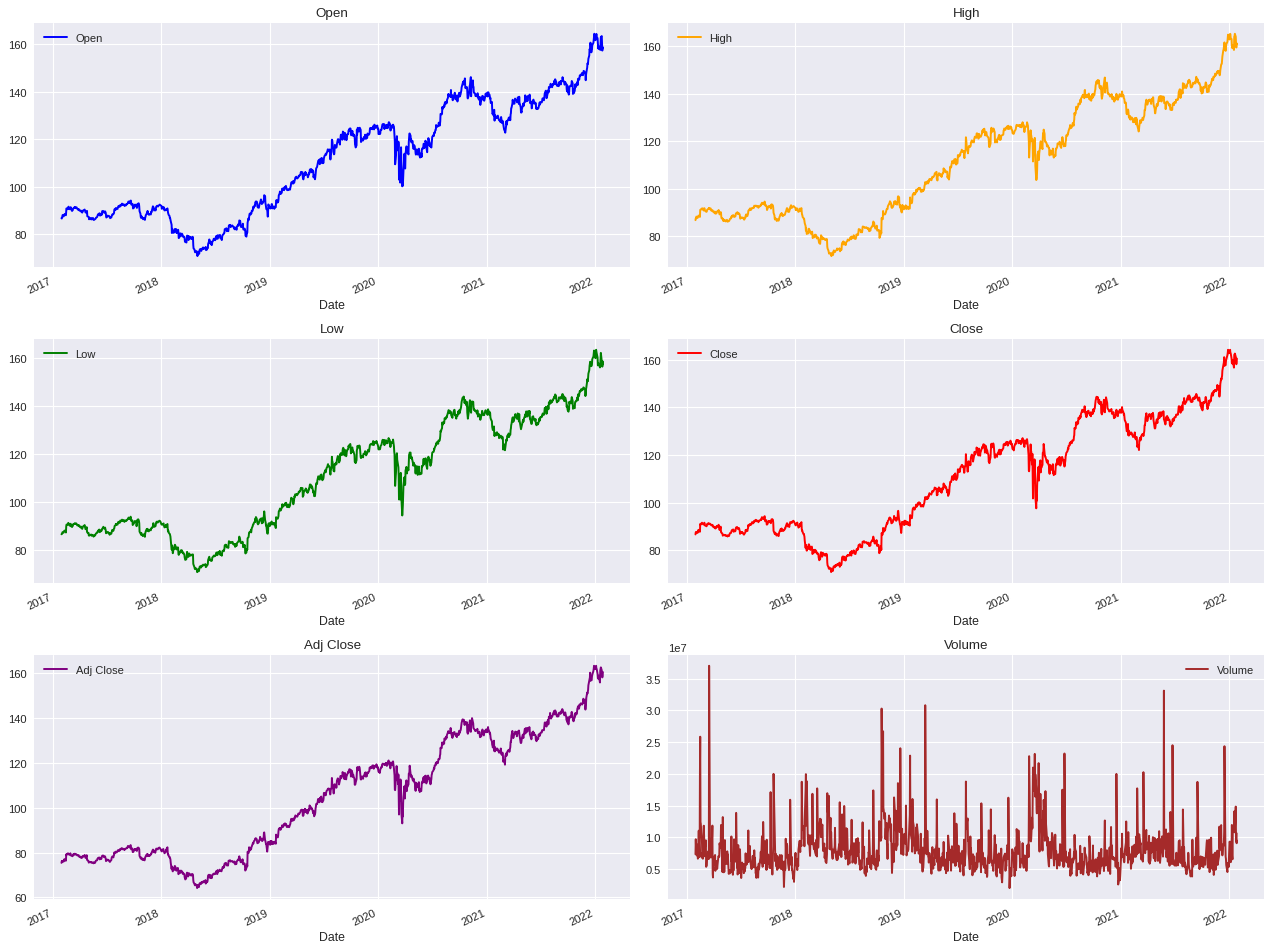

In [9]:
plt.style.use('seaborn')
titles = [
    "Open",
    "High",
    "Low",
    "Close",
    "Adj Close",
    "Volume",
]
colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
]
# date_time_key = "Date"


def show_raw_visualization(data):
    # time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=3, ncols=2, figsize=(16, 12), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(titles)):
        c = colors[i % (len(colors))]
        t_data = data[titles[i]]
        # t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(titles[i]),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()
    # plt.savefig('Timeseries.png', dpi=1200)
    plt.show()


show_raw_visualization(df)

##### 1.2.2 Correlation Heatmap

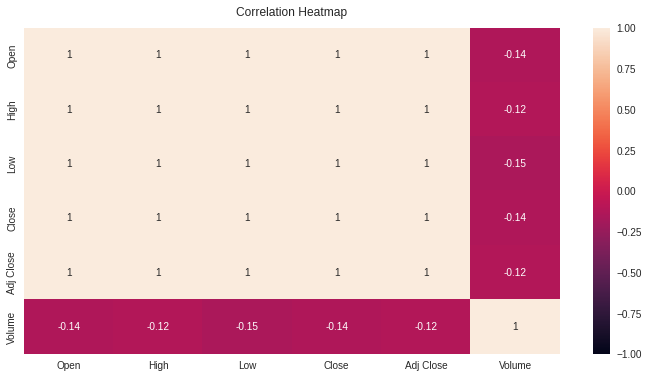

In [10]:
# Increase the size of the heatmap.
plt.figure(figsize=(12, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title). Set
# the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the
# correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad=12)
# plt.savefig('Timeseries_Heatmap.png', dpi=1200)
plt.show()

##### 1.2.3 BoxPlot

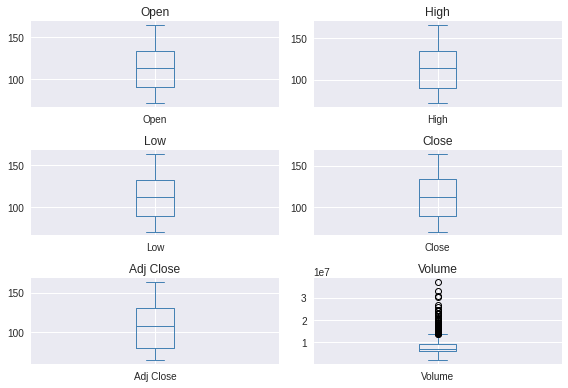

In [11]:
def draw_boxplot(df, variables, n_rows, n_cols):
    fig = plt.figure()
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].plot.box(ax=ax, color='steelblue', grid=True)
        ax.set_title(var_name)
    plt.tight_layout()
    # plt.savefig('Timeseries_BoxPlot.png', format='png', dpi=1200)
    plt.show()


draw_boxplot(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2)

##### 1.2.4 Histogram

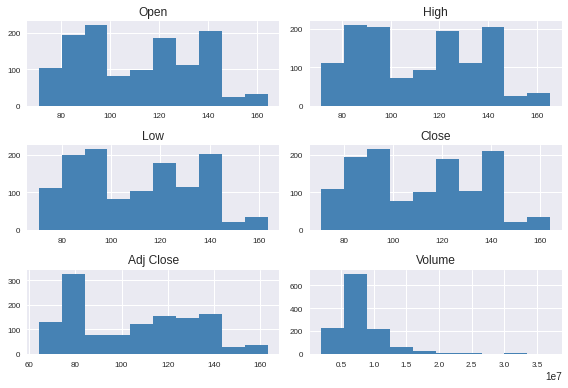

In [12]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig = plt.figure()
    for i, var_name in enumerate(variables):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        df[var_name].hist(bins=10, ax=ax, color='steelblue', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=True)
        ax.set_title(var_name)
    plt.tight_layout()
    # plt.savefig('Timeseries_Histograms.png', dpi=1200)
    plt.show()


draw_histograms(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2)

##### 1.2.5 LagPlot

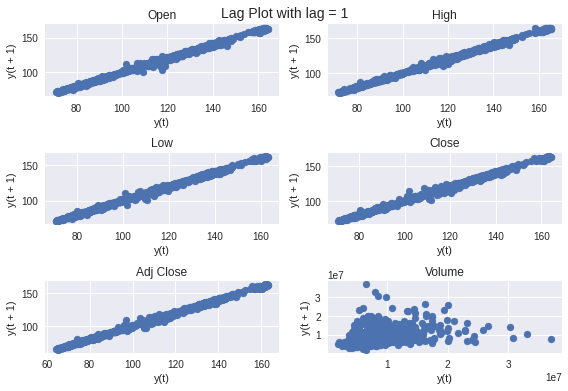

In [13]:
def draw_lag_plot(df, variables, n_rows, n_cols, lag):
    for m in lag:
        fig = plt.figure()
        fig.suptitle('Lag Plot with lag = {}'.format(m), fontsize=14)
        for i, var_name in enumerate(variables):
            ax = fig.add_subplot(n_rows, n_cols, i + 1)
            pd.plotting.lag_plot(df[var_name], lag=m)
            ax.set_title(var_name)
        plt.tight_layout()
        # plt.savefig('LagPlot with lag = {}.png'.format(m), dpi=1200)
        plt.show()


draw_lag_plot(df, df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']], 3, 2, [1])

## 2. Data prepocessing

#### 2.1 Data Cleaning

In [14]:
# Check missing values
print(df.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [15]:
# There aren't missing value
# Replace missing values by interpolation
def replace_missing(attribute):
    return attribute.interpolate(inplace=True)


# replace_missing(df['Open'])
# ....

In [16]:
# Detect and remove outliers with IQR
def detect_remove_outliers(column):
    # IQR
    Q1 = np.percentile(df[f'{column}'], 25, interpolation='midpoint')
    Q3 = np.percentile(df[f'{column}'], 75, interpolation='midpoint')
    IQR = Q3 - Q1

    # Above Upper bound
    upper = df[f'{column}'] >= (Q3 + 1.5 * IQR)
    # print("Upper bound:", upper)
    print("Upper bound outliers:", f'{column}', np.where(upper))

    # Below Lower bound
    lower = df[f'{column}'] <= (Q1 - 1.5 * IQR)
    # print("Lower bound:", lower)
    print("Lower bound:", f'{column}', np.where(lower))
    return

# There may be potential outliers in the Volume column, but they won't be considered outliers because
# a large volume of transactions is related to a change in the closing price
# For the other columns it was previously verified graphically with the boxplot that there aren't outliers.
# Also mathematically, with the IQR method, the same result is gotten.

# for i in titles:
#     detect_remove_outliers(f'{i}')

#### 2.2 Data Splitting

In [17]:
# Fast_ml library
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target='Close', method='sorted',
                                                                            sort_by_col='Date', train_size=0.6,
                                                                            valid_size=0.2, test_size=0.2)
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

X_train.shape: (756, 5) y_train.shape: (756,)
X_valid.shape: (252, 5) y_valid.shape: (252,)
X_test.shape: (252, 5) y_test.shape: (252,)


#### 2.3 Data Transformation

In [18]:
# Normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

'''
# Other transformers
# StandardScaler
st_scaler = StandardScaler()
X_train = st_scaler.fit_transform(X_train)
X_test = st_scaler.transform(X_test)

# PowerTransformer
pt = PowerTransformer()
X_train = pt.fit_transform(X_train)
X_test = pt.transform(X_test)
'''


'\n# Other transformers\n# StandardScaler\nst_scaler = StandardScaler()\nX_train = st_scaler.fit_transform(X_train)\nX_test = st_scaler.transform(X_test)\n\n# PowerTransformer\npt = PowerTransformer()\nX_train = pt.fit_transform(X_train)\nX_test = pt.transform(X_test)\n'

#### 2.4 Set "***Window size***"

In [19]:
# Create a 3D input
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps, :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


TIME_STEPS = 2
X_test, y_test = create_dataset(X_test, y_test, TIME_STEPS)
X_train, y_train = create_dataset(X_train, y_train, TIME_STEPS)
X_valid, y_valid = create_dataset(X_valid, y_valid, TIME_STEPS)

print('All shapes are: (batch, time, features)')
print('X_train.shape:', X_train.shape, 'y_train.shape:', y_train.shape)
print('X_valid.shape:', X_valid.shape, 'y_valid.shape:', y_valid.shape)
print('X_test.shape:', X_test.shape, 'y_test.shape:', y_test.shape)

All shapes are: (batch, time, features)
X_train.shape: (754, 2, 5) y_train.shape: (754,)
X_valid.shape: (250, 2, 5) y_valid.shape: (250,)
X_test.shape: (250, 2, 5) y_test.shape: (250,)


## 3. Model Choice and Learning

In [ ]:
def build_model0(hp):
    model = Sequential()
    model.add(SimpleRNN(hp.Int('input_unit', min_value=32, max_value=512, step=32), return_sequences=True,
                        input_shape=(X_train.shape[1], X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(SimpleRNN(hp.Int('layer_2_neurons', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam', )  # ,metrics=['mse']
    return model


def build_model1(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit', min_value=32, max_value=512, step=32), return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True))
    model.add(LSTM(hp.Int('layer_2_neurons', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def build_model2(hp):
    model = Sequential()
    model.add(GRU(hp.Int('input_unit', min_value=32, max_value=512, step=32), return_sequences=True,
                  input_shape=(X_train.shape[1], X_train.shape[2])))
    #  model.add(Dropout(0.2))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True))
        #  model.add(Dropout(0.2))
    model.add(LSTM(hp.Int('layer_2_neurons', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='relu'))  # or linear
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def build_model3(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     # adding filter size or kernel size
                     kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                     # activation function
                     activation='relu',
                     padding='same',
                     input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Conv1D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                         kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                         activation='relu',
                         padding='same',
                         ))
        model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [20]:
def fashion_mnist_fn(x_train, y_train, x_val, y_val, params):
	  # Step 1: reset the tensorflow backend session.
    tf.keras.backend.clear_session()
    # Step 2: Define the model with variable hyperparameters.
    conv_dropout = float(params['conv_dropout'])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(64, 5, padding='same', activation=params['activation'],
                     input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(tf.keras.layers.Dropout(conv_dropout))

    model.add(tf.keras.layers.Conv1D(64, 5, padding='same', activation=params['activation']))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2, padding='same'))
    model.add(tf.keras.layers.Dropout(conv_dropout))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(
        optimizer='adam',
        loss='mse',
        # metrics=['mse']
    )


    out = model.fit(
        x_train, y_train, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        verbose=0,
        validation_data=[x_val, y_val],
    )
    return out, model


para = {
    'activation': ['relu', 'elu'],
    'conv_dropout': [0.25, 0.4],
    'batch_size': [100, 180],
    'epochs': [10, 50, 100],
}

scan_results = ta.Scan(x=X_train,
                 y=y_train,
                 params=para,
                 model=fashion_mnist_fn,
                 experiment_name= 'ssss',
                 x_val=X_valid,
                 y_val=y_valid)

100%|██████████| 24/24 [02:12<00:00,  5.54s/it]


In [ ]:
r = ta.Reporting('/content/ssss/020122190652.csv')

# returns the results dataframe
r.data
#r.plot_kde

# returns the highest value for 'val_fmeasure'
#r.high('mse')

# returns the number of rounds it took to find best model
#r.rounds2high()

# draws a histogram for 'val_acc'
#r.plot_hist()
